Using device: cpu
Epoch [1/5000]  Loss: 0.694861
Epoch [500/5000]  Loss: 0.071490
Epoch [1000/5000]  Loss: 0.053868
Epoch [1500/5000]  Loss: 0.046633
Epoch [2000/5000]  Loss: 0.041017
Epoch [2500/5000]  Loss: 0.031723
Epoch [3000/5000]  Loss: 0.025447
Epoch [3500/5000]  Loss: 0.019616
Epoch [4000/5000]  Loss: 0.016499
Epoch [4500/5000]  Loss: 0.014203
Epoch [5000/5000]  Loss: 0.012789

Final Loss: 0.012789
Training accuracy: 0.9900000095367432


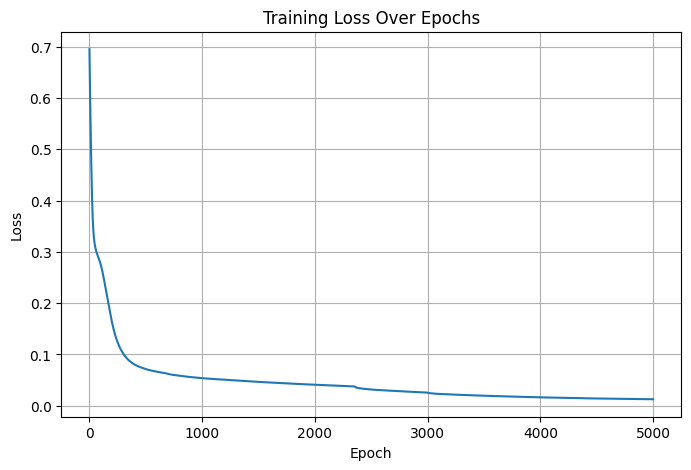

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1️⃣ Create dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32).to(device)  # Move to GPU
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)  # Move to GPU

# 2️⃣ Define Model
import torch.nn as nn

class myMLP(nn.Module):
    """
    Simple Feedforward Neural Network (Fully Connected Neural Network).

    Architecture:
        Input layer  -> Fully connected layer (fc1)
                    -> ReLU activation
                    -> Fully connected layer (fc2)
                    -> Output logits (no sigmoid applied)

    Args:
        input_dim (int): Number of input features.
        hidden_dim (int): Number of neurons in the hidden layer.
        output_dim (int): Number of output neurons (e.g., 1 for binary classification).

    Notes:
        - This network outputs raw logits.
        - Sigmoid activation is NOT applied here because BCEWithLogitsLoss
          already includes a sigmoid internally for better numerical stability.
    """

    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialize the layers of the neural network.
        """
        super(myMLP, self).__init__()

        # First fully connected layer: transforms input features to hidden representation
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Activation introduces non-linearity so the network can learn complex patterns

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()


        # Second fully connected layer: maps hidden representation to output logits
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            Tensor: Output logits of shape (batch_size, output_dim)
        """

        # Pass input through first linear layer
        x = self.fc1(x)

        # Apply non-linear activation
        x = self.relu(x)
        # x = self.tanh(x)

        # Pass through final linear layer to produce logits
        x = self.fc2(x)   # No sigmoid (handled by BCEWithLogitsLoss)

        return x


# 3️⃣ Initialize model and move to GPU
model = myMLP(input_dim=2, hidden_dim=16, output_dim=1).to(device)

# 4️⃣ Loss + Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 5️⃣ Training loop
epochs = 5000
losses = []

for epoch in range(epochs):

    # Forward pass: feed input data X through the model to get predictions
    outputs = model(X)

    # Compute the loss between predicted outputs and true targets y
    # The loss function (criterion) measures how wrong the predictions are
    loss = criterion(outputs, y)

    # Store the scalar loss value for later analysis (e.g., plotting training curve)
    # .item() converts the tensor loss into a standard Python float
    losses.append(loss.item())

    # Clear previous gradients from the optimizer
    # This is necessary because PyTorch accumulates gradients by default
    optimizer.zero_grad()

    # Backward pass: compute gradients of the loss with respect to model parameters
    # This uses automatic differentiation (backpropagation)
    loss.backward()

    # Update model parameters using the computed gradients
    # The optimizer applies the update rule (e.g., SGD, Adam)
    optimizer.step()

    # 🔎 Print loss iteratively
    if (epoch + 1) % 500 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}")

print(f"\nFinal Loss: {losses[-1]:.6f}")

# 6️⃣ Prediction
with torch.no_grad():
    logits = model(X)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).float()

accuracy = (y_pred == y).float().mean()
print("Training accuracy:", accuracy.item())

# 7️⃣ Plot Loss Curve (plotting happens on CPU)
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

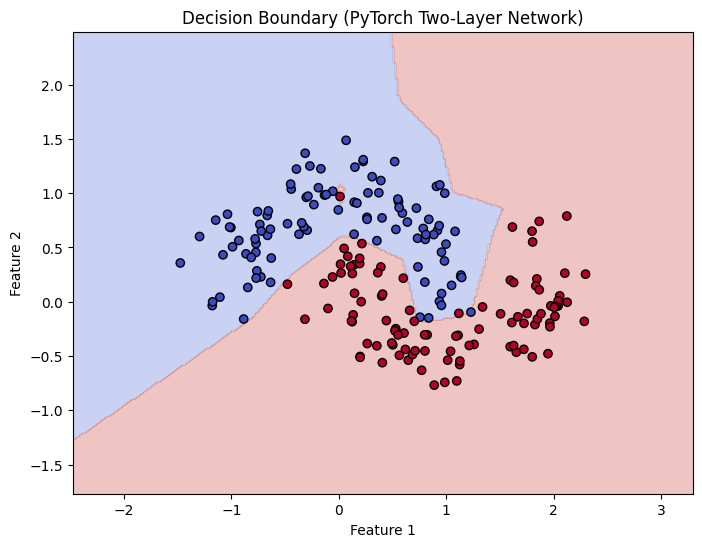

In [5]:
# 7️⃣ Decision Boundary Visualization
plt.figure(figsize=(8,6))
X_np, y_np = make_moons(n_samples=200, noise=0.2, random_state=42)

# Create mesh grid
x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Predict over grid
with torch.no_grad():
    logits = model(grid_tensor)
    probs = torch.sigmoid(logits)
    Z = (probs > 0.5).float()

Z = Z.numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

# Plot training points
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap="coolwarm", edgecolors='k')

plt.title("Decision Boundary (PyTorch Two-Layer Network)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()